# Understanding the Business

## About Company
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

## Problem
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. 


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score,roc_auc_score,classification_report,balanced_accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
#from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(style="darkgrid")
pd.set_option('display.max_columns', 50) 

In [3]:
train_df = pd.read_csv('train_ctrUa4K.csv')

# Understanding the data

In [4]:
print('No of records in training data :', train_df.shape)

No of records in training data : (614, 13)


In [5]:
train_df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
display(train_df.describe([0.5,0.75,0.95,0.99,0.995,0.998]))

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
95%,14583.000000,4997.400000,297.800000,360.00000,1.000000
99%,32540.410000,8895.890000,496.360000,480.00000,1.000000
99.5%,39943.620000,19434.500000,600.000000,480.00000,1.000000
99.8%,60721.276000,30709.838000,640.900000,480.00000,1.000000


In [7]:
def feature_engineering(dataframe,train_test='train'):
    dataframe['LoanAmount'] = dataframe['LoanAmount'] *  1000
    dataframe['TotalIncome'] = dataframe['ApplicantIncome'] + dataframe['CoapplicantIncome']
    dataframe.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)
    
    if train_test=='train':
        dataframe = dataframe.loc[dataframe['TotalIncome'] < 20000]
    
    dataframe['Gender'].fillna( dataframe['Gender'].dropna().mode().values[0], inplace=True)
    dataframe['Married'].fillna( dataframe['Married'].dropna().mode().values[0], inplace=True)
    dataframe['Dependents'].fillna( dataframe['Dependents'].dropna().mode().values[0], inplace=True)
    dataframe['Self_Employed'].fillna( dataframe['Self_Employed'].dropna().mode().values[0], inplace=True)
    dataframe['Loan_Amount_Term'].fillna( dataframe['Loan_Amount_Term'].dropna().mode().values[0], inplace=True)
    dataframe['Credit_History'].fillna(-1,inplace=True)
    dataframe['LoanAmount'] = dataframe['LoanAmount'].fillna( dataframe['LoanAmount'].dropna().median() )


    dataframe['Dependents'] = dataframe['Dependents'].str.rstrip('+').astype(np.int) # to replace 3+ with 3
    dataframe['Gender'] = dataframe['Gender'].map({'Female':0,'Male':1}).astype(np.int)
    dataframe['Married'] = dataframe['Married'].map({'No':0, 'Yes':1}).astype(np.int)
    dataframe['Education'] = dataframe['Education'].map({'Not Graduate':0, 'Graduate':1}).astype(np.int)
    dataframe['Self_Employed'] = dataframe['Self_Employed'].map({'No':0, 'Yes':1}).astype(np.int)
    
    if train_test=='train':
        dataframe['Loan_Status'] = dataframe['Loan_Status'].map({'N':0, 'Y':1}).astype(np.int)
    #train_df['Property_Area'] = train_df['Property_Area'].astype(np.int)

    dataframe['Very_ShortTerm'] = dataframe['Loan_Amount_Term'].map(lambda x: 1 if x<=60 else 0).astype(np.int)
    dataframe['ShortTerm'] = dataframe['Loan_Amount_Term'].map(lambda x: 1 if x>60 and x<=180 else 0).astype(np.int)
    dataframe['LongTerm'] = dataframe['Loan_Amount_Term'].map(lambda x: 1 if x>180 and x<=300  else 0).astype(np.int)
    dataframe['Very_LongTerm'] = dataframe['Loan_Amount_Term'].map(lambda x: 1 if x>300 else 0).astype(np.int)
    dataframe.drop('Loan_Amount_Term', axis=1, inplace=True)


    dataframe['Bad_CreHist'] = dataframe['Credit_History'].map(lambda x: 1 if x==0 else 0).astype(np.int)
    dataframe['Good_CreHist'] = dataframe['Credit_History'].map(lambda x: 1 if x==1 else 0).astype(np.int)
    dataframe['Unknown_CreHist'] = dataframe['Credit_History'].map(lambda x: 1 if x==-1 else 0).astype(np.int)
    dataframe.drop('Credit_History', axis=1, inplace=True)
    
    dataframe['Income_Loan_Ratio'] = dataframe['TotalIncome'] / dataframe['LoanAmount']
    
    dataframe.drop(['Loan_ID'], axis=1, inplace=True)

    return dataframe

##*************************************************************************************************************************************## 

def dummy_creation(dataframe):
    dummy_df = dataframe[['Dependents','Property_Area']]
    dummy_df = pd.get_dummies(data=dummy_df,columns=dummy_df.columns,drop_first=True)

    dataframe.drop(columns=['Dependents','Property_Area'],inplace=True)
    dataframe = pd.concat([dataframe,dummy_df],axis=1)

    dataframe['Dependents_1'] = dataframe['Dependents_1'].astype(np.int)
    dataframe['Dependents_2'] = dataframe['Dependents_2'].astype(np.int)
    dataframe['Dependents_3'] = dataframe['Dependents_3'].astype(np.int)
    dataframe['Property_Area_Semiurban'] = dataframe['Property_Area_Semiurban'].astype(np.int)
    dataframe['Property_Area_Urban'] = dataframe['Property_Area_Urban'].astype(np.int)
    
    return dataframe


##*************************************************************************************************************************************## 
def model_evaluation_plot(y_train,y_train_pred,y_test,y_test_pred):
    '''
    Function is used for model evaluation using common scoring metrics
    y_train, y_train_ped : Actual and predicted values of training set
    y_test,y_test_pred : Actual and predicted values of test set
    
    '''
    
    print('\n------------Recall/Sensitivity (Churn Prediction Accuracy) score------------')
    print('train set:', round(recall_score(y_train, y_train_pred),3))
    print('Test set:',  round(recall_score(y_test, y_test_pred),3))

    print('\n------------Specificity (Non Churn Prediction Accuracy) score------------')
    tn1, fp1, fn1, tp1 = confusion_matrix(y_train, y_train_pred).ravel()
    tn2, fp2, fn2, tp2 = confusion_matrix(y_test, y_test_pred).ravel()
    print('train set:', round((tn1/(tn1+fp1)),3))
    print('test set:', round((tn2/(tn2+fp2)),3))
        
    print('\n------------Precision score------------')
    print('train set:', round(precision_score(y_train, y_train_pred),3))
    print('test set:',  round(precision_score(y_test, y_test_pred),3))
    
    print('\n------------F1 score------------')
    print('train set:', round(f1_score(y_train, y_train_pred),3))
    print('test set:',  round(f1_score(y_test, y_test_pred),3))
    
    print('\n------------Accuracy score------------')
    print('train set:', round(accuracy_score(y_train, y_train_pred),3))
    print('Test set:',  round(accuracy_score(y_test, y_test_pred),3))
    

In [8]:
train_df = feature_engineering(train_df)
train_df = dummy_creation(train_df)

In [9]:
display(train_df.describe([0.5,0.75,0.95,0.99,0.995,0.998]))

,Gender,Married,Education,Self_Employed,LoanAmount,Loan_Status,TotalIncome,Very_ShortTerm,ShortTerm,LongTerm,Very_LongTerm,Bad_CreHist,Good_CreHist,Unknown_CreHist,Income_Loan_Ratio,Dependents_1,Dependents_2,Dependents_3,Property_Area_Semiurban,Property_Area_Urban
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,0.813758,0.652685,0.775168,0.132550,139192.953020,0.692953,6172.110604,0.008389,0.080537,0.026846,0.884228,0.145973,0.775168,0.078859,0.048511,0.166107,0.167785,0.077181,0.380872,0.327181
std,0.389629,0.476517,0.417822,0.339373,68791.009897,0.461657,3187.131366,0.091285,0.272351,0.161768,0.320220,0.353376,0.417822,0.269745,0.029557,0.372490,0.373989,0.267103,0.486009,0.469578
min,0.000000,0.000000,0.000000,0.000000,9000.000000,0.000000,1442.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012090,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,126000.000000,1.000000,5298.500000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.041086,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,160000.000000,1.000000,7146.250000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.050859,0.000000,0.000000,0.000000,1.000000,1.000000
95%,1.000000,1.000000,1.000000,1.000000,261250.000000,1.000000,13003.250000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.089582,1.000000,1.000000,1.000000,1.000000,1.000000
99%,1.000000,1.000000,1.000000,1.000000,406550.000000,1.000000,17274.850000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.157869,1.000000,1.000000,1.000000,1.000000,1.000000
99.5%,1.000000,1.000000,1.000000,1.000000,495025.000000,1.000000,18169.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.250356,1.000000,1.000000,1.000000,1.000000,1.000000
99.8%,1.000000,1.000000,1.000000,1.000000,499240.000000,1.000000,18806.040000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.282289,1.000000,1.000000,1.000000,1.000000,1.000000


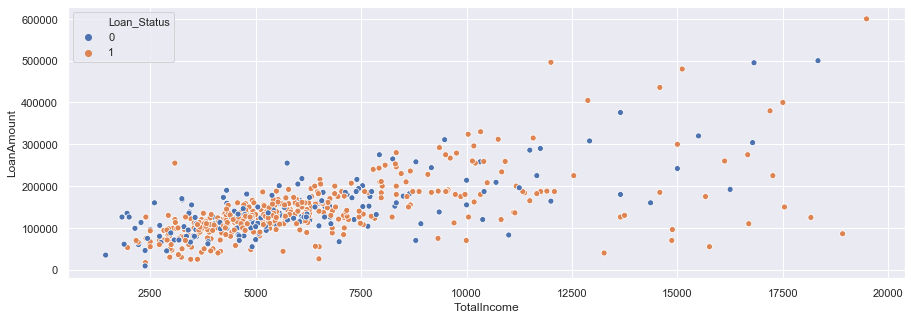

In [10]:
#sns.regplot(x="ApplicantIncome", y="LoanAmount", data=train_df)
plt.figure(figsize=(15,5))
sns.scatterplot(x="TotalIncome", y="LoanAmount", data=train_df,hue='Loan_Status')
plt.show()

In [37]:
#display(round(train_df.isnull().sum(axis=0)/len(train_df)*100,2)) # Pecentage of NaN per column in train set
#display(round(train_df.isna().sum(axis=0)/len(train_df)*100,2))
#display(len(train_df))

In [ ]:
train_df.reset_index(inplace=True,drop=True)

In [71]:
X = train_df.drop(['Loan_Status'], axis=1)
y = train_df.Loan_Status
X_columns = X.columns
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [72]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.values
y_test = y_test.values
display(y_train.shape)
display(Counter(y_train))
display(Counter(y_test))

(476,)

Counter({1: 340, 0: 136})

Counter({0: 47, 1: 73})

In [73]:
X_cat_cols = X.select_dtypes(include=['int32']).columns.tolist()
X_num_cols = X.drop(X_cat_cols,axis=1).columns.tolist()

SS = StandardScaler() # Use standard scaler for scaling continous features
X_train = pd.concat([X_train[X_cat_cols],pd.DataFrame(SS.fit_transform(X_train.drop(X_cat_cols, axis=1)))], axis=1)

X_train.columns = X_cat_cols+X_num_cols

In [38]:
#display(round(X.isnull().sum(axis=0)/len(X)*100,2)) # Pecentage of NaN per column in train set
#display(round(X.isna().sum(axis=0)/len(X)*100,2))
#X.isna().sum()
#X_train.info()

display(round(X.describe(),2))

## Model Preparation

In [50]:
#X_train.describe()

,Gender,Married,Education,Self_Employed,Very_ShortTerm,ShortTerm,LongTerm,Very_LongTerm,Bad_CreHist,Good_CreHist,Unknown_CreHist,Dependents_1,Dependents_2,Dependents_3,Property_Area_Semiurban,Property_Area_Urban,LoanAmount,TotalIncome,Income_Loan_Ratio
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.00000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,0.813983,0.637104,0.726369,0.131834,0.006639,0.071012,0.022994,0.899355,0.235409,0.688072,0.076519,0.180598,0.143528,0.05591,0.326618,0.317296,-0.008469,-0.021553,-0.036857
std,0.380090,0.473438,0.435185,0.324589,0.078972,0.249677,0.142705,0.292935,0.420406,0.458951,0.259540,0.374494,0.343515,0.22517,0.460516,0.459652,0.940242,0.926857,0.876192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-1.735980,-1.487547,-1.130989
25%,1.000000,0.000000,0.131592,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.529263,-0.631000,-0.439357
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.185088,-0.241355,-0.253420
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.298676,0.303422,0.079122
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,6.559157,4.148465,9.224585


from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42,ratio='minority')
X_columns = X_train.columns
X_train, y_train = sm.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train,columns=X_columns)
y_train = pd.DataFrame(y_train,columns=['Loan_Status'])
y_train['Loan_Status'].value_counts().plot(kind='bar', title='Count (Loan Target)')

### XGBoost 

### Random Forest

### ADA Boosting

## KNN

In [80]:
# hyperparameter tuning

# specify range of hyperparameters
param_grid = \
{ 'n_neighbors': [3,5],
  'weights': ['uniform', 'distance'],
  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
  'leaf_size': [20,25,30],
  'metric':['euclidean','minkowski'],
   'p': [1,2]           
}

# specify model
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scoring = ['accuracy', 'recall', 'precision']
knn =KNeighborsClassifier()

# set up GridSearchCV()

model_cv_knn = GridSearchCV(estimator = knn,
                        param_grid = param_grid, 
                        scoring= scoring, 
                        refit='accuracy',
                        cv = folds,
                        verbose = 3,
                        return_train_score=True)                         
                
#model_cv_svc.fit(X, y)
model_cv_knn.fit(X_train, y_train)
cv_result_knn =pd.DataFrame(model_cv_knn.cv_results_)
display(cv_result_knn.sort_values(by='rank_test_accuracy'))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform, accuracy=(train=0.871, test=0.708), precision=(train=0.863, test=0.750), recall=(train=0.974, test=0.882), total=   0.2s
[CV] algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform 
[CV]  algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform, accuracy=(train=0.858, test=0.832), precision=(train=0.859, test=0.817), recall=(train=0.960, test=0.985), total=   0.0s
[CV] algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform 
[CV]  algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform, accuracy=(train=0.845, test=0.853), precision=(train=0.859, test=0.855), recall=(train=0.938, test=0.956), total=   0.0s
[CV] algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform, accuracy=(train=0.853, test=0.800), precision=(train=0.844, test=0.810), recall=(train=0.974, test=0.941), total=   0.0s
[CV] algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform 
[CV]  algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=uniform, accuracy=(train=0.864, test=0.747), precision=(train=0.859, test=0.782), recall=(train=0.967, test=0.897), total=   0.0s
[CV] algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=distance 
[CV]  algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=distance, accuracy=(train=1.000, test=0.688), precision=(train=1.000, test=0.744), recall=(train=1.000, test=0.853), total=   0.0s
[CV] algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=distance 
[CV]  algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, p=1, weights=distance,

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:   43.5s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,...,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision
124,0.006547,0.002204,0.011053,0.002100,kd_tree,25,minkowski,5,1,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 25, 'met...",0.770833,0.831579,0.810526,0.778947,0.800000,0.798377,0.021858,1,0.852632,0.84252,0.832021,0.853018,0.84252,0.844542,...,0.955882,0.016109,37,0.977941,0.970588,0.966912,0.985294,0.970588,0.974265,0.006577,0.773810,0.817073,0.812500,0.790123,0.810127,0.800727,0.016316,109,0.841772,0.835443,0.827044,0.8375,0.835443,0.83544,0.004792
92,0.005308,0.001943,0.012115,0.001770,ball_tree,30,minkowski,5,1,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",0.770833,0.831579,0.810526,0.778947,0.800000,0.798377,0.021858,1,0.852632,0.84252,0.832021,0.853018,0.84252,0.844542,...,0.955882,0.016109,37,0.977941,0.970588,0.966912,0.985294,0.970588,0.974265,0.006577,0.773810,0.817073,0.812500,0.790123,0.810127,0.800727,0.016316,109,0.841772,0.835443,0.827044,0.8375,0.835443,0.83544,0.004792
12,0.007172,0.001590,0.012792,0.001595,auto,20,minkowski,5,1,uniform,"{'algorithm': 'auto', 'leaf_size': 20, 'metric...",0.770833,0.831579,0.810526,0.778947,0.800000,0.798377,0.021858,1,0.852632,0.84252,0.832021,0.853018,0.84252,0.844542,...,0.955882,0.016109,37,0.977941,0.970588,0.966912,0.985294,0.970588,0.974265,0.006577,0.773810,0.817073,0.812500,0.790123,0.810127,0.800727,0.016316,109,0.841772,0.835443,0.827044,0.8375,0.835443,0.83544,0.004792
172,0.004349,0.003117,0.016037,0.002864,brute,25,minkowski,5,1,uniform,"{'algorithm': 'brute', 'leaf_size': 25, 'metri...",0.770833,0.831579,0.810526,0.778947,0.800000,0.798377,0.021858,1,0.852632,0.84252,0.832021,0.853018,0.84252,0.844542,...,0.955882,0.016109,37,0.977941,0.970588,0.966912,0.985294,0.970588,0.974265,0.006577,0.773810,0.817073,0.812500,0.790123,0.810127,0.800727,0.016316,109,0.841772,0.835443,0.827044,0.8375,0.835443,0.83544,0.004792
156,0.004816,0.002061,0.014175,0.005136,brute,20,minkowski,5,1,uniform,"{'algorithm': 'brute', 'leaf_size': 20, 'metri...",0.770833,0.831579,0.810526,0.778947,0.800000,0.798377,0.021858,1,0.852632,0.84252,0.832021,0.853018,0.84252,0.844542,...,0.955882,0.016109,37,0.977941,0.970588,0.966912,0.985294,0.970588,0.974265,0.006577,0.773810,0.817073,0.812500,0.790123,0.810127,0.800727,0.016316,109,0.841772,0.835443,0.827044,0.8375,0.835443,0.83544,0.004792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,0.007655,0.002621,0.009424,0.003110,auto,30,minkowski,3,1,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.718750,0.831579,0.821053,0.747368,0.757895,0.775329,0.043684,181,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,...,0.902941,0.046131,181,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.766234,0.817073,0.849315,0.805556,0.792208,0.806077,0.027461,13,1.000000,1.000000,1.000000,1.0000,1.000000,1.00000,0.000000
73,0.004099,0.001263,0.006390,0.001953,ball_tree,25,minkowski,3,1,distance,"{'algorithm': 'ball_tree',

In [81]:
print('Best score : ', round(model_cv_knn.best_score_,3), 'is obtained with ', model_cv_knn.best_params_)
model_knn = model_cv_knn.best_estimator_
#print("\n Best Estimator:",model_xgb)
model_knn.fit(X_train, y_train)

### PREDICT Churn rate ###
y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

model_evaluation_plot(y_train,y_train_pred,y_test,y_test_pred)

Best score :  0.798 is obtained with  {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

------------Recall/Sensitivity (Churn Prediction Accuracy) score------------
train set: 0.976
Test set: 0.918

------------Specificity (Non Churn Prediction Accuracy) score------------
train set: 0.507
test set: 0.064

------------Precision score------------
train set: 0.832
test set: 0.604

------------F1 score------------
train set: 0.899
test set: 0.728

------------Accuracy score------------
train set: 0.842
Test set: 0.583


# SVM

In [64]:
# hyperparameter tuning with Random Forest

# specify range of hyperparameters
param_grid = { #'C': [1,10,100,1000],             
              'C': range(1,25,1),  
              # 'C': [2],
              'gamma': [0.00001,0.0001,0.001,0.01,0.1,1],#,'scale', 'auto'], 
              # 'gamma': [0.001], 
              #'kernel': ['linear','rbf','poly','sigmoid'],
              'kernel': ['rbf'],
              #'class_weight': [{0:1, 1:0.5}]
                'class_weight': ['balanced']
              
}

# specify model
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scoring = ['accuracy', 'recall', 'precision']
svc = SVC(random_state=42,shrinking=False)

# set up GridSearchCV()

model_cv_svc = GridSearchCV(estimator = svc,
                        param_grid = param_grid, 
                        scoring= scoring, 
                        refit='accuracy',
                        cv = folds,
                        verbose = 3,
                        return_train_score=True)                         
                
#model_cv_svc.fit(X, y)
model_cv_svc.fit(X_train, y_train)
cv_result_svc =pd.DataFrame(model_cv_svc.cv_results_)
display(cv_result_svc.sort_values(by='rank_test_accuracy'))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] C=1, class_weight=balanced, gamma=1e-05, kernel=rbf .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1, class_weight=balanced, gamma=1e-05, kernel=rbf, accuracy=(train=0.529, test=0.515), precision=(train=0.900, test=0.750), recall=(train=0.066, test=0.044), total=   3.0s
[CV] C=1, class_weight=balanced, gamma=1e-05, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=1e-05, kernel=rbf, accuracy=(train=0.689, test=0.721), precision=(train=0.709, test=0.721), recall=(train=0.643, test=0.721), total=   0.0s
[CV] C=1, class_weight=balanced, gamma=1e-05, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=1e-05, kernel=rbf, accuracy=(train=0.535, test=0.522), precision=(train=0.880, test=1.000), recall=(train=0.081, test=0.044), total=   0.0s
[CV] C=1, class_weight=balanced, gamma=1e-05, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=1e-05, kernel=rbf, accuracy=(train=0.605, test=0.625), precision=(train=0.852, test=0.947), recall=(train=0.254, test=0.265), total=   0.1s
[CV] C=1, class_weight=balanced, gamma=1e-05, kernel=rbf ..........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV]  C=1, class_weight=balanced, gamma=1e-05, kernel=rbf, accuracy=(train=0.528, test=0.515), precision=(train=0.857, test=1.000), recall=(train=0.066, test=0.029), total=   0.0s
[CV] C=1, class_weight=balanced, gamma=0.0001, kernel=rbf ............
[CV]  C=1, class_weight=balanced, gamma=0.0001, kernel=rbf, accuracy=(train=0.531, test=0.515), precision=(train=0.905, test=0.750), recall=(train=0.070, test=0.044), total=   0.0s
[CV] C=1, class_weight=balanced, gamma=0.0001, kernel=rbf ............
[CV]  C=1, class_weight=balanced, gamma=0.0001, kernel=rbf, accuracy=(train=0.689, test=0.721), precision=(train=0.709, test=0.721), recall=(train=0.643, test=0.721), total=   0.0s
[CV] C=1, class_weight=balanced, gamma=0.0001, kernel=rbf ............
[CV]  C=1, class_weight=balanced, gamma=0.0001, kernel=rbf, accuracy=(train=0.539, test=0.522), precision=(train=0.889, test=1.000), recall=(train=0.088, test=0.044), total=   0.0s
[CV] C=1, class_weight=balanced, gamma=0.0001, kernel=rbf ......

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   48.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_kernel,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_recall,...,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision
35,0.034311,0.005480,0.006396,0.005887,6,balanced,1,rbf,"{'C': 6, 'class_weight': 'balanced', 'gamma': ...",0.845588,0.897059,0.845588,0.904412,0.852941,0.869118,0.026059,1,0.979779,0.968750,0.974265,0.976103,0.974265,0.974632,0.003564,0.867647,...,0.879412,0.048685,42,0.970588,0.977941,0.966912,0.977941,0.966912,0.972059,0.004987,0.830986,0.846154,0.821918,0.966102,0.863636,0.865759,0.052132,38,0.988764,0.960289,0.981343,0.974359,0.981343,0.977220,0.009614
41,0.030458,0.000083,0.009862,0.000887,7,balanced,1,rbf,"{'C': 7, 'class_weight': 'balanced', 'gamma': ...",0.845588,0.897059,0.838235,0.904412,0.852941,0.867647,0.027512,2,0.981618,0.970588,0.977941,0.976103,0.977941,0.976838,0.003602,0.867647,...,0.879412,0.048685,42,0.974265,0.977941,0.970588,0.977941,0.974265,0.975000,0.002751,0.830986,0.846154,0.810811,0.966102,0.863636,0.863538,0.054150,39,0.988806,0.963768,0.985075,0.974359,0.981481,0.978698,0.008858
29,0.029439,0.001789,0.010307,0.003072,5,balanced,1,rbf,"{'C': 5, 'class_weight': 'balanced', 'gamma': ...",0.830882,0.897059,0.830882,0.904412,0.852941,0.863235,0.031746,3,0.979779,0.966912,0.974265,0.976103,0.974265,0.974265,0.004192,0.838235,...,0.879412,0.050431,42,0.974265,0.977941,0.974265,0.977941,0.966912,0.974265,0.004027,0.826087,0.846154,0.792208,0.950820,0.863636,0.855781,0.053123,49,0.985130,0.956835,0.974265,0.974359,0.981343,0.974386,0.009715
47,0.029938,0.005727,0.009707,0.001528,8,balanced,1,rbf,"{'C': 8, 'class_weight': 'balanced', 'gamma': ...",0.845588,0.882353,0.845588,0.897059,0.845588,0.863235,0.022108,3,0.981618,0.972426,0.979779,0.974265,0.979779,0.977574,0.003564,0.867647,...,0.873529,0.042214,51,0.974265,0.981618,0.974265,0.974265,0.977941,0.976471,0.002941,0.830986,0.842105,0.813333,0.965517,0.850746,0.860538,0.053959,44,0.988806,0.963899,0.985130,0.974265,0.981550,0.978730,0.008836
59,0.030040,0.000876,0.008125,0.003135,10,balanced,1,rbf,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.845588,0.875000,0.845588,0.904412,0.845588,0.863235,0.023529,3,0.985294,0.974265,0.981618,0.979779,0.979779,0.980147,0.003564,0.867647,...,0.873529,0.034300,49,0.981618,0.981618,0.977941,0.977941,0.977941,0.979412,0.001801,0.830986,0.840000,0.813333,0.966102,0.850746,0.860233,0.054337,45,0.988889,0.967391,0.985185,0.981550,0.981550,0.980913,0.007287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,0.030839,0.001654,0.012143,0.003981,2,balanced,1e-05,rbf,"{'C': 2, 'class_weight': 'balanced', 'gamma': ...",0.514706,0.720588,0.522059,0.625000,0.514706,0.579412,0.082064,110,0.529412,0.689338,0.534926,0.604779,0.527574,0.577206,0.063038,0.044118,...,0.220588,0.264869,110,0.066176,0.643382,0.080882,0.253676,0.066176,0.222059,0.222280,0.750000,0.720588,1.000000,0.947368,1.000000,0.883591,0.122952,1,0.900000,0.708502,0.880000,0.851852,0.857143,0.839499,0.067712
96,0.030268,0.000094,0.011274,0.003547,17,balanced,1e

In [66]:
print('Best score : ', round(model_cv_svc.best_score_,3), 'is obtained with ', model_cv_svc.best_params_)
model_svc = model_cv_svc.best_estimator_
#print("\n Best Estimator:",model_xgb)
model_svc.fit(X_train, y_train)

### PREDICT Churn rate ###
y_train_pred = model_svc.predict(X_train)
y_test_pred = model_svc.predict(X_test)

model_evaluation_plot(y_train,y_train_pred,y_test,y_test_pred)

Best score :  0.869 is obtained with  {'C': 6, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}

------------Recall/Sensitivity (Churn Prediction Accuracy) score------------
train set: 0.971
Test set: 1.0

------------Specificity (Non Churn Prediction Accuracy) score------------
train set: 0.976
test set: 0.0

------------Precision score------------
train set: 0.976
test set: 0.608

------------F1 score------------
train set: 0.973
test set: 0.756

------------Accuracy score------------
train set: 0.974
Test set: 0.608


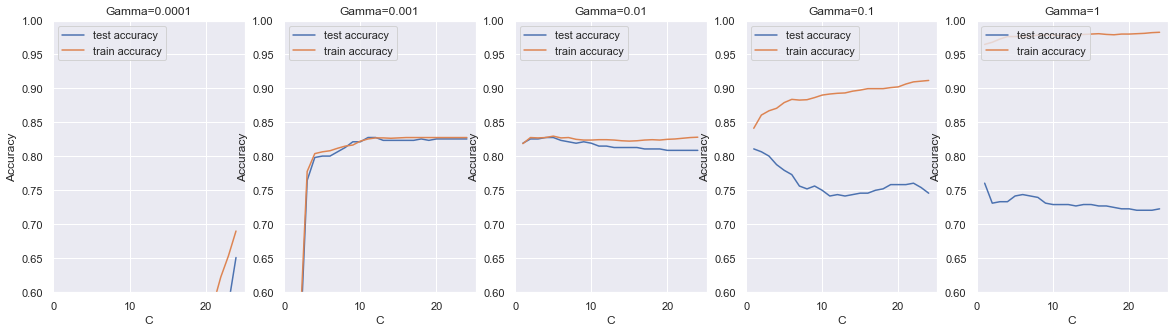

In [31]:
cv_result_svc['param_C'] = cv_result_svc['param_C']#.astype('int')
gamma= [0.0001,0.001,0.01,0.1,1]
col_count = len(gamma)
plt_count = 0

if col_count > 5:
    row_count=2
else:
    row_count=1

plt.figure(figsize=(20,5*row_count))
for g in gamma:
    plt_count+=1
    plt.subplot(row_count,col_count,plt_count)
    gamma_df = cv_result_svc[cv_result_svc['param_gamma']==g]

    plt.plot(gamma_df["param_C"], gamma_df["mean_test_accuracy"])
    plt.plot(gamma_df["param_C"], gamma_df["mean_train_accuracy"])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    title="Gamma="+str(g)
    plt.title(title)
    plt.ylim([0.60, 1])
    plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
    #£plt.xscale('log')

plt.show()

### Prediction on Test set

In [32]:
test_df = pd.read_csv('test_lAUu6dG.csv')
test_df_copy = test_df.copy()

In [34]:
test_df = feature_engineering(test_df,'test')
test_df = dummy_creation(test_df)

X_test = pd.concat([test_df[X_cat_cols],pd.DataFrame(SS.transform(test_df.drop(X_cat_cols, axis=1)))], axis=1)
X_test.columns = X_cat_cols+X_num_cols

In [35]:
X_test.describe()

,Gender,Married,Education,Self_Employed,Very_ShortTerm,ShortTerm,LongTerm,Very_LongTerm,Bad_CreHist,Good_CreHist,Unknown_CreHist,Dependents_1,Dependents_2,Dependents_3,Property_Area_Semiurban,Property_Area_Urban,LoanAmount,TotalIncome,Income_Loan_Ratio
count,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000
mean,0.809264,0.634877,0.771117,0.100817,0.010899,0.070845,0.029973,0.888283,0.160763,0.760218,0.079019,0.158038,0.160763,0.108992,0.316076,0.381471,-0.043076,0.053493,0.016115
std,0.393417,0.482122,0.420687,0.301498,0.103970,0.256915,0.170745,0.315448,0.367814,0.427533,0.270137,0.365275,0.367814,0.312054,0.465578,0.486411,0.867357,1.624211,1.192879
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.579468,-1.388209,-1.286017
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.540797,-0.639740,-0.468391
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.199317,-0.312050,-0.258893
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.263105,0.242430,0.080969
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.847738,20.718815,15.543577


In [36]:
#test_df_copy['Loan_Status_xgb'] = model_xgb.predict(X_test)
#test_df_copy['Loan_Status_rf'] = model_rf.predict(X_test)
#test_df_copy['Loan_Status_ada'] = model_rus.predict(X_test)
test_df_copy['Loan_Status_ada'] = model_svc.predict(X_test)

#test_df_copy['Loan_Status'] = test_df_copy['Loan_Status_xgb'] + test_df_copy['Loan_Status_rf'] + test_df_copy['Loan_Status_ada']
#test_df_copy['Loan_Status'] = test_df_copy['Loan_Status'].map({0:'N', 1:'N', 2:'Y', 3:'Y'})

#test_df_copy['Loan_Status'] = model_lr.predict(X_test)
test_df_copy['Loan_Status'] = model_rf.predict(X_test)
test_df_copy['Loan_Status'] = test_df_copy['Loan_Status'].map({0:'N', 1:'Y'})

ValueError: feature_names mismatch: ['Gender', 'Married', 'Education', 'Self_Employed', 'LoanAmount', 'TotalIncome', 'Very_ShortTerm', 'ShortTerm', 'LongTerm', 'Very_LongTerm', 'Bad_CreHist', 'Good_CreHist', 'Unknown_CreHist', 'Income_Loan_Ratio', 'Dependents_1', 'Dependents_2', 'Dependents_3', 'Property_Area_Semiurban', 'Property_Area_Urban'] ['Gender', 'Married', 'Education', 'Self_Employed', 'Very_ShortTerm', 'ShortTerm', 'LongTerm', 'Very_LongTerm', 'Bad_CreHist', 'Good_CreHist', 'Unknown_CreHist', 'Dependents_1', 'Dependents_2', 'Dependents_3', 'Property_Area_Semiurban', 'Property_Area_Urban', 'LoanAmount', 'TotalIncome', 'Income_Loan_Ratio']

In [ ]:
test_df_copy[[ 'Loan_ID', 'Loan_Status']].to_csv('prediction.csv',index=False)